<a href="https://colab.research.google.com/github/SarveshPatil99/Adversarial-Robustness-Enhancement/blob/main/TML_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown --fuzzy https://drive.google.com/file/d/1-8d_JyH50-b23vnQXSn2BLM1E4Mh-0k5/view?usp=drive_link
!unzip -q speckle_0.01.zip

Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1-8d_JyH50-b23vnQXSn2BLM1E4Mh-0k5 

unzip:  cannot find or open speckle_0.01.zip, speckle_0.01.zip.zip or speckle_0.01.zip.ZIP.


In [2]:
!gdown --fuzzy https://drive.google.com/uc?id=18MZZwgKjTGlB2Y4Esw_lRIvbpOaANbnh
!unzip -q original_dataset_stylegan3_10000.zip

Downloading...
From: https://drive.google.com/uc?id=18MZZwgKjTGlB2Y4Esw_lRIvbpOaANbnh
To: /content/original_dataset_stylegan3_10000.zip
100% 2.12G/2.12G [00:24<00:00, 86.9MB/s]


In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import os

In [4]:
dataset = 'original'
new_dataset = 'noisy_data/speckle_0.01'
for split in ['train','val','test']:
  for label in ['real','fake']:
    path = f'{dataset}/{split}/{label}'
    Path(f'{new_dataset}/{split}/{label}').mkdir(parents=True, exist_ok=True)
    files = os.listdir(path)
    for img_file in tqdm(files,desc=f'{split}/{label}'):
      img = cv2.imread(f'{path}/{img_file}')/255
      img = img + img*np.random.normal(0,0.01,img.shape)
      img = np.clip(img, 0,1)
      cv2.imwrite(f'{new_dataset}/{split}/{label}/{img_file}',(img*255).astype(np.uint8))

train/real:   0%|          | 0/8000 [00:00<?, ?it/s]

train/fake:   0%|          | 0/8000 [00:00<?, ?it/s]

val/real:   0%|          | 0/1000 [00:00<?, ?it/s]

val/fake:   0%|          | 0/1000 [00:00<?, ?it/s]

test/real:   0%|          | 0/1000 [00:00<?, ?it/s]

test/fake:   0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
import tensorflow as tf
import numpy as np
import pathlib
import os
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, ReLU, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
import pickle
from matplotlib import pyplot as plt
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [6]:
noise_type = 'speckle_0.01'

In [7]:
dataset_name = f'/content/noisy_data/{noise_type}'
train_dir = pathlib.Path(f'{dataset_name}/train')
val_dir = pathlib.Path(f'{dataset_name}/val')
test_dir = pathlib.Path(f'{dataset_name}/test')
train_len = len(list(train_dir.glob('*/*.png')))
val_len = len(list(val_dir.glob('*/*.png')))
classes = np.array(os.listdir(f'{dataset_name}/train'))
class_dict = dict(zip(classes,range(len(classes))))
print(train_len, val_len)
print(class_dict)

img_height = 256
img_width = 256
batch_size = 16

def create_label(image_path):
  class_name = tf.strings.split(image_path,'/')[-2]
  return tf.cast(classes == class_name,tf.float32)

def load(image_path):

  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image) / 255
  # image = tf.image.resize(image, [img_height, img_width])

  label = create_label(image_path)

  return image, label

train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'), shuffle=False).concatenate(tf.data.Dataset.list_files('/content/original/train/*/*', shuffle=False))
train_ds = train_ds.shuffle(len(train_ds), reshuffle_each_iteration=False)
train_ds = train_ds.map(load, num_parallel_calls=tf.data.AUTOTUNE)
# train_ds = train_ds.cache('tmp')
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
train_ds_length = len(train_ds)

val_ds = tf.data.Dataset.list_files(str(val_dir/'*/*'), shuffle=False).concatenate(tf.data.Dataset.list_files('/content/original/val/*/*', shuffle=False))
val_ds = val_ds.shuffle(len(val_ds), reshuffle_each_iteration=False)
val_ds = val_ds.map(load, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.cache()
val_ds = val_ds.batch(batch_size)
val_ds_length = len(val_ds)

print(f'train_ds_length: {train_ds_length}, val_ds_length: {val_ds_length}')

16000 2000
{'real': 0, 'fake': 1}
train_ds_length: 2000, val_ds_length: 250


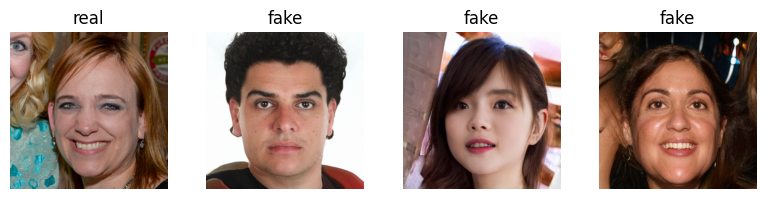

In [8]:
for x, y in train_ds.take(1):
  pass
# plt.figure(figsize=(32,10))
plt.figure(figsize=(8,2))
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.imshow(x[i])
  plt.axis('off')
  plt.title(classes[tf.argmax(y[i])])
plt.tight_layout()

In [10]:
def conv_bn_relu(filters,x,idx,label):
    x = SeparableConv2D(filters, 3, padding='same', kernel_initializer='he_uniform',name=f'conv_{idx}{label}')(x)
    x = BatchNormalization(name=f'bn_{idx}{label}')(x)
    x = ReLU(name=f'relu_{idx}{label}')(x)
    # x = Dropout(rate=0.1,name=f'dropout_{idx}{label}')(x)
    return x

def create_model(input_shape = (256, 256, 3)):
  input_layer = Input(input_shape,name='input')
  n_filters = 16
  x = input_layer
  for i in range(5):
    x = conv_bn_relu(n_filters,x,i,'a')
    x = conv_bn_relu(n_filters,x,i,'b')
    x = MaxPooling2D(name=f'maxpool_{i}')(x)
    n_filters = int(n_filters*2)
  # x = Flatten(name='flatten')(x)
  x = GlobalAveragePooling2D(name='global_pool')(x)
  # x = Dense(32,activation='relu',name='dense_0')(x)
  # x = Dropout(rate=0.2,name=f'dropout_dense')(x)
  x = Dense(2,activation='softmax',name='dense_0', dtype = 'float32')(x)

  model = Model(inputs = [input_layer], outputs = [x])

  return model

In [ ]:
lr = 1e-3
epochs = 50
rLR_patience = 5
es_patience = 10
loss = 'categorical_crossentropy'
metrics = ['accuracy']
n_filters = 16
model_type = noise_type

model_filename = f'{model_type}_sg3=20k_n={n_filters}_epoch={epochs}_lr={lr:.0e}'

model_path = f'saved/models/{model_filename}.h5'
history_path = f'saved/histories/{model_filename}.pkl'
pathlib.Path('saved/models').mkdir(exist_ok=True,parents=True)
pathlib.Path('saved/histories').mkdir(exist_ok=True,parents=True)

checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', mode = 'max', factor=1/np.sqrt(10), patience = rLR_patience, min_lr=1e-6, verbose = 1)
earlystopper = EarlyStopping(monitor='val_accuracy', mode = 'max', patience = es_patience, verbose=1)
callbacks = [checkpoint, reduce_lr, earlystopper]

model = create_model()
print(model.count_params())
optimizer = RMSprop(learning_rate = lr)
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
hist = model.fit(train_ds, epochs = epochs, validation_data = val_ds, callbacks = callbacks, verbose = 1)
with open(history_path, 'wb') as file_pi:
  pickle.dump(hist.history, file_pi)

142989
Epoch 1/50
2000/2000 [==============================] - ETA: 0s - loss: 0.7082 - accuracy: 0.5079
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to saved/models/speckle_0.01_sg3=20k_n=16_epoch=50_lr=1e-03.h5
2000/2000 [==============================] - 170s 77ms/step - loss: 0.7082 - accuracy: 0.5079 - val_loss: 0.8690 - val_accuracy: 0.5000 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
2000/2000 [==============================] - ETA: 0s - loss: 0.6992 - accuracy: 0.5147
Epoch 2: val_accuracy did not improve from 0.50000
2000/2000 [==============================] - 129s 64ms/step - loss: 0.6992 - accuracy: 0.5147 - val_loss: 0.6959 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/50
2000/2000 [==============================] - ETA: 0s - loss: 0.6971 - accuracy: 0.5228
Epoch 3: val_accuracy improved from 0.50000 to 0.55250, saving model to saved/models/speckle_0.01_sg3=20k_n=16_epoch=50_lr=1e-03.h5
2000/2000 [==============================] - 132s 66ms/step - loss: 0.6971 - accuracy: 0.5228 - val_loss: 0.6864 - val_accuracy: 0.5525 - lr: 0.0010
Epoch 4/50
1773/2000 [=========================>....] - ETA: 13s - loss: 0.6895 - accuracy: 0.5461

In [ ]:
model.load_weights(model_path)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model(model_path)

In [ ]:
test_ds = tf.data.Dataset.list_files(str(test_dir/'*/*'), shuffle=False)
test_ds = test_ds.shuffle(len(test_ds), reshuffle_each_iteration=False)
test_ds = test_ds.map(load, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache()
test_ds = test_ds.batch(batch_size)
test_ds_length = len(test_ds)

print(f'test_ds_length: {test_ds_length}')

test_ds_length: 63


In [ ]:
model.evaluate(test_ds)

63/63 [==============================] - 4s 57ms/step - loss: 0.7933 - accuracy: 0.5970


[0.7933207750320435, 0.597000002861023]